In [27]:
#pip install tensorflow
#pip install tensorflow-io[tensorflow]  Installs a tensorflow-io compatible with our tensorflow package

In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import shutil

In [4]:
# We place r in front to make our string a "raw" string
metadata = pd.read_csv(r"C:\Users\laury\OneDrive\Stalinis kompiuteris\SE4CSAI\Group-07__\Data\My own\Audio detection\Audio files\warblrb10k_public_wav\Detection_metadata.csv")

In [5]:
os.getcwd()
wav_names = os.listdir(r"C:\Users\laury\OneDrive\Stalinis kompiuteris\SE4CSAI\Group-07__\Data\My own\Audio detection\Audio files\warblrb10k_public_wav\wav")
print(wav_names[:5])

['0011e7f9-ec1e-4f3a-a70f.wav', '001277e4-24c2-4b8e-a6a8.wav', '001fceab-9866-48e8-a169.wav', '00268cc3-03e8-4e62-bee2.wav', '0042e80d-b0de-4129-8008.wav']


In [6]:
def load_wav_make_simple(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)  # Returns a byte encoded string
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # We decode the string and specify the channel that we want: mono or stereo
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)  # Squeezing so that we remove the trailing axis from wav. Wav shape was (n, 1), we only need the n
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)  # Format of int instead of string
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) # Resampling the wave in the format of Int and 16000Hz, so we significantly reduced the size of the wav file.
    return wav

Define the bird file paths and not bird file paths

In [7]:
os.chdir(r"C:\Users\laury\OneDrive\Stalinis kompiuteris\SE4CSAI\Group-07__\Data\My own\Audio detection\Audio files\warblrb10k_public_wav")
print(os.getcwd())
#print(metadata[:5])
print(os.listdir())
is_bird = (metadata.loc[metadata['hasbird'] == 1, 'itemid']).tolist()  #Get itemid where hasbird == 1
not_bird = (metadata.loc[metadata['hasbird'] == 0, 'itemid']).tolist() 

C:\Users\laury\OneDrive\Stalinis kompiuteris\SE4CSAI\Group-07__\Data\My own\Audio detection\Audio files\warblrb10k_public_wav
['Detection_metadata.csv', 'wav', 'wav_negative']


In [189]:
# With this code block I moved the non-bird sounds to another folder.
source = r'C:\Users\laury\OneDrive\Stalinis kompiuteris\SE4CSAI\Group-07__\Data\My own\Audio detection\Audio files\warblrb10k_public_wav\wav'
destination = r'C:\Users\laury\OneDrive\Stalinis kompiuteris\SE4CSAI\Group-07__\Data\My own\Audio detection\Audio files\warblrb10k_public_wav\wav_negative'

# for f in not_bird:
#     src_path = os.path.join(source, f + ".wav")
#     dst_path = os.path.join(destination, f + ".wav")
#     shutil.move(src_path, dst_path)

In [190]:
birds = tf.data.Dataset.list_files(source+'\*.wav')
not_birds = tf.data.Dataset.list_files(destination+'\*.wav')

In [191]:
positives = tf.data.Dataset.zip((birds, tf.data.Dataset.from_tensor_slices(tf.ones(len(birds)))))
negatives = tf.data.Dataset.zip((not_birds, tf.data.Dataset.from_tensor_slices(tf.zeros(len(not_birds)))))
data = positives.concatenate(negatives)

In [11]:
# Ran for 22min 43sec
# lengths = []
# for file in os.listdir(source):
#     tensor_wave = load_wav_make_simple(os.path.join(source, file))
#     lengths.append(len(tensor_wave))

In [12]:
# Not important!
tf.math.reduce_mean(lengths)
161373 / 16000
# On average our bird sounds are 10.0858125 seconds long
# Let's take 150 000Hz, that will equal to a little less than 10s for each spectogram

10.0858125

In [73]:
# Not important!
tf.math.reduce_max(lengths)
774617 / 16000
# Max is 48.4135625 seconds long

48.4135625

In [74]:
# Not important!
tf.math.reduce_min(lengths)
115170 / 16000
# Min is 7.198125 seconds long

7.198125

In [17]:
def preprocess(file_path, label): 
    wav = load_wav_make_simple(file_path) # Load our data into waveform
    wav = wav[:80000] # We are going to take a bit less than 10 seconds of each waveform
    zero_padding = tf.zeros([80000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=1000, frame_step=50)  # Short time fourier transform
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

source = r'C:\Users\laury\OneDrive\Stalinis kompiuteris\SE4CSAI\Group-07__\Data\My own\Audio detection\Audio files\warblrb10k_public_wav\wav\0a3c5d54-bf32-4a1d-aab4.wav'
myreturn = preprocess(source, 1)
print(myreturn[0].shape)

(1581, 513, 1)


In [193]:
# Not important!
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [194]:
# Not important!
spectrogram, label = preprocess(filepath, label)

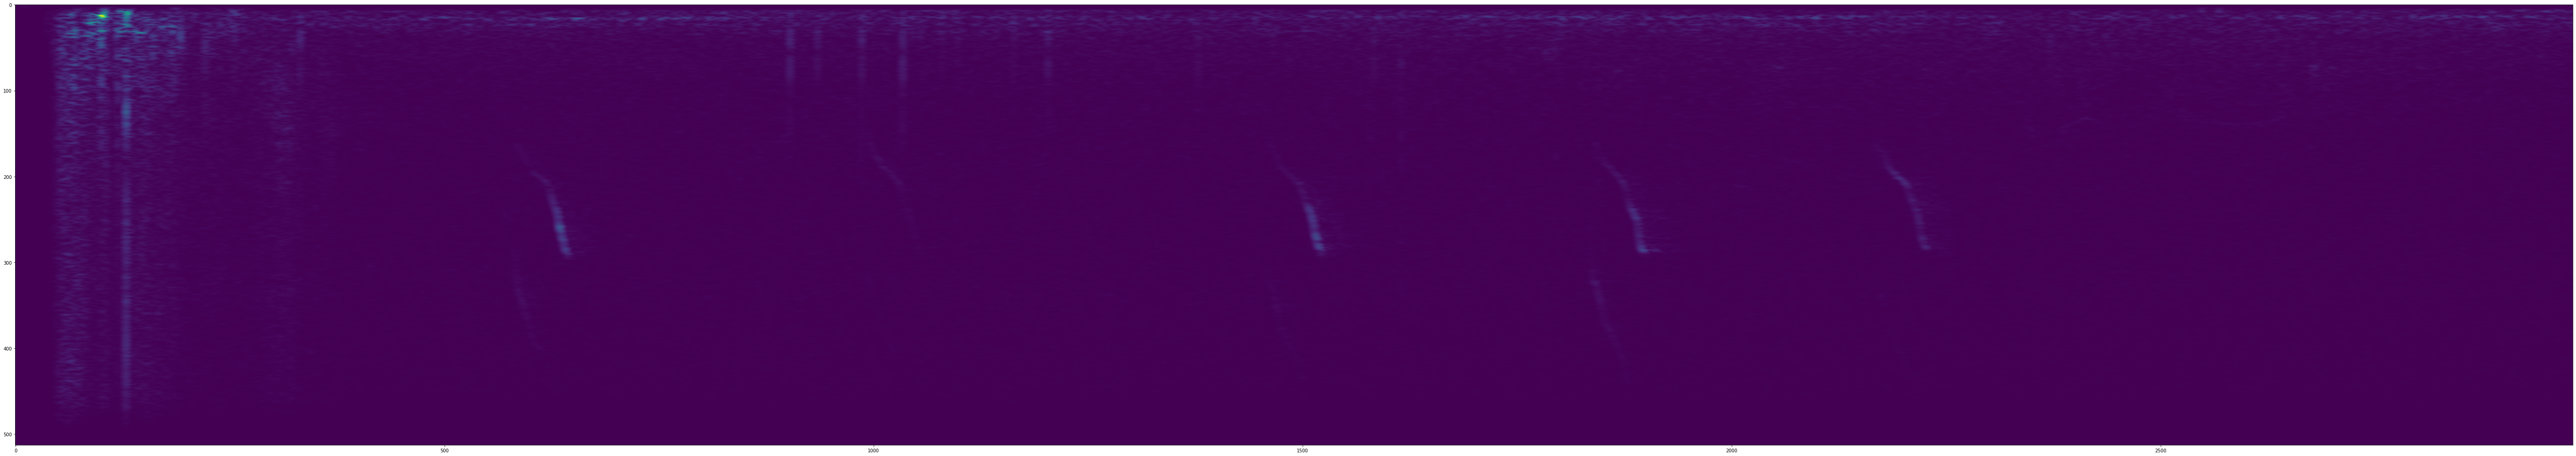

In [78]:
# Not important!
plt.figure(figsize=(100,50))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [79]:
# Not important!
data.as_numpy_iterator().next() # Currently holds a string

(b'C:\\Users\\laury\\OneDrive\\Stalinis kompiuteris\\SE4CSAI\\Group-07__\\Data\\My own\\Audio detection\\Audio files\\warblrb10k_public_wav\\wav\\190fb255-1c3b-42de-bf08.wav',
 1.0)

In [195]:
# Pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16) # We are going to train on 16 samples at a time
data = data.prefetch(8) # We are going to prefetch 8 examples, so this prevents any cpu bottlenecking

In [196]:
# Not important!
len(data) # 500 because we have grouped samples into groups of 16
len(data)*.7 # 350 samples

350.0

In [197]:
train = data.take(350)
test = data.skip(350).take(150)

In [198]:
samples, labels = train.as_numpy_iterator().next()

In [199]:
samples.shape
# We got 16 spectrograms with a shape of (2981, 513, 1)

(16, 1581, 513, 1)

Building the model

In [200]:
from tensorflow.keras.models import Sequential # For sequential model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D # Three layers. Flatten helps to go from Conv2D to Dense layer

In [222]:
model = Sequential()

In [223]:
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1581, 513, 1))) # We want 16 different kernels of shape 3 by 3, activation function relu and input shape has to match our spectrogram shape

In [224]:
model.add(MaxPool2D(pool_size=(2, 2)))

In [225]:
model.add(Conv2D(16, (3,3), activation='relu'))

In [226]:
model.add(MaxPool2D(pool_size=(2, 2)))

In [227]:
model.add(MaxPool2D(pool_size=(2, 2)))

In [228]:
model.add(Flatten())

In [229]:
model.add(Dense(64, activation='relu'))

In [230]:
model.add(Dense(1, activation='sigmoid'))

In [231]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]) # Using Adam optimizes, BinaryCrossentropy(because our output is binary)

In [232]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 1579, 511, 16)     160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 789, 255, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 787, 253, 16)      2320      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 393, 126, 16)     0         
 g2D)                                                            
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 196, 63, 16)      0         
 g2D)                                                            
                                                     

In [233]:
hist = model.fit(train, epochs=1, validation_data=test) # Can increase the epochs to try and increaase  accuracy

350/350 [==============================] - ETA: 0s - loss: 0.4606 - recall_10: 0.9942 - precision_10: 0.9783

: 

: 